In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/DeepShack/train')

In [1]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from model import MultiScaleCNN, FullyConnected
from image_handlers import ImageLoader

#  Multi-Scale CNN model training strategy 

1. Train a model with mall data
2. Further train the model with ShackCam data
3. Adding FC layers and training only the FC layers by setting `mscnn_layer.trainable = False`

# 1. Train a model with mall data

### Load mall data

Total image samples 2000


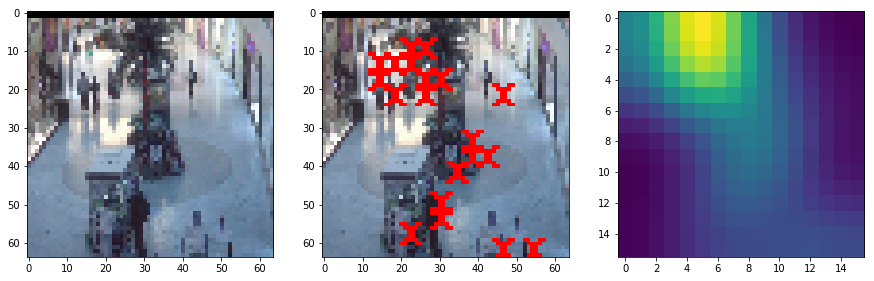

In [2]:
new_shape = 64

mall = ImageLoader(new_shape=new_shape, image_dir='data/mall')
mall.load_train_data()
mall.plot_image(filename='seq_000499.jpg')
print('Total image samples', mall.count)

### Create a model

In [ ]:
input_shape = (new_shape, new_shape, 3)
model = MultiScaleCNN(input_shape=input_shape, name='mall')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   331840      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   200768      conv2d[0][0]                     
_____________________________________

###  Split data to train/test

In [ ]:
train_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(mall.org_img, mall.gaussian_img, train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (400, 64, 64, 3) x_test (1600, 64, 64, 3)
y_train (400, 16, 16, 1) y_test (1600, 16, 16, 1)


/Users/Ikkei/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Assign optimizer and compile a model

In [ ]:
model.train(x_train, y_train, epochs=2, batch_size=16)

Instructions for updating:
Use tf.cast instead.
Train on 360 samples, validate on 40 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
360/360 [==============================] - 937s 3s/sample - loss: 289706.2834 - val_loss: 1.4618
Epoch 2/2
 64/360 [====>.........................] - ETA: 12:48 - loss: 1.4433

In [ ]:
model.evaluate(x_test, y_test)

# 2. Further train the same model with ShackCam data

### Load shackcam data

In [ ]:
shackcam = ImageLoader(new_shape=new_shape, image_dir='data/shackcam')
shackcam.load_train_data()
shackcam.plot_image(i=500)
print('Total image samples', shackcam.count)

### Split data to train/test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(shackcam.org_img, shackcam.gaussian_img, 
                                                    train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

### Load pre-trained weights

In [ ]:
model = MultiScaleCNN(input_shape=input_shape, name='shackcam', 
                      existing_model_path='results/mall_model.h5')

### Assign optimizer and compile a model

In [ ]:
model.train(x_train, y_train, epochs=2, batch_size=16)

### Save results and inspect loss

In [ ]:
model.evaluate(x_test, y_test)

# Adding FC layers and training only the FC layers

### Read line counts, align order as shackcam annotations, remove files without counts

In [ ]:
counts = pd.read_csv('data/shackcam/line_counts.csv', names=['file', 'line_count'], header=None)
counts = counts[counts.file.isin(shackcam.files)]
gaussian_img = np.array([shackcam.data[f]['gaussian_img'] for f in counts.file])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(gaussian_img, counts.line_count.values, 
                                                    train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

In [ ]:
input_shape = (new_shape//4, new_shape//4, 1)
model = FullyConnected(input_shape=input_shape, name='shackcam_fc')

In [ ]:
model.train(x_train, y_train, epochs=2, batch_size=16)

In [ ]:
model.evaluate(x_test, y_test)

### Predict

In [ ]:
i = 10
shackcam.plot_image(i=i)
model.model.predict(shackcam.gaussian_img[i].reshape((1, *input_shape)))[0][0]